# Анализ результата АВ теста


В нашем эксперименте проверялась эффективность рекомендательной системы постов для пользователей. Задача стояла повышение конверсии лайков к постам. Исследуемая метрика была выбрана `ctr`, т.к. она количественно отображает отношение лайкнутых постов к проссмотренным. Эксперимент проводился с `1 мая 2023 года` по `7 мая 2023 года`.  В ходе эксперимента использовались две группы: `группа №1` - контрольная группа, `группа №2` - целевая группа. 

Нулевая гипотеза `H0`: различия в `ctr` между дву группами нет

Альтернативная гипотеза `H1`: различия в `ctr` между группами есть

***Задача:*** провести анализ результатов теста

---

Импортируем необходимые библиотеки

In [1]:
import pandahouse as ph 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns 
from scipy import stats 
%matplotlib inline

Выполняем подключение к БД.

Извлекаем из БД пользователя, его группу, его количество лайков, количество просмотренных постов, `ctr`. Результат записываем в `DataFrame`

In [2]:
connection = {
                'host': 'https://clickhouse.lab.karpov.courses',
                'database':'simulator_20230520',
                'user':'student', 
                'password':'dpo_python_2020'
            }


q = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
'''

# Выполняем запрос к БД
df = ph.read_clickhouse(q, connection=connection)

Посмотрим на общий `ctr` в двух группам, имеются ли там различия

In [5]:
ctr_1 = df[df['exp_group']==1]['likes'].sum() / df[df['exp_group']==1]['views'].sum()
ctr_2 = df[df['exp_group']==2]['likes'].sum() / df[df['exp_group']==2]['views'].sum()


print(f'ctr 1 группы: {round(ctr_1,3)}\nctr 2 группы {round(ctr_2,3)}')

ctr 1 группы: 0.208
ctr 2 группы 0.198


Как мы видим, `ctr` целевой группы получился меньше, теперь мы хотим убедиться, являются ли полученные результаты статистически значемыми или получены случайно

Посмотрим на количество участников в группах

In [4]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


Посмотрим на распределение `ctr` двух групп

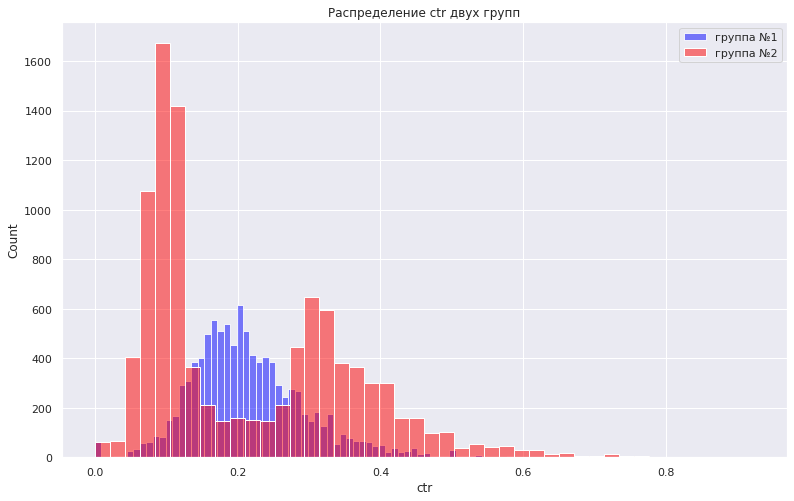

In [15]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.set_theme()
g = sns.histplot(df[df['exp_group']==1]['ctr'], color='blue', alpha=0.5, label='группа №1')
g = sns.histplot(df[df['exp_group']==2]['ctr'], color='red', alpha=0.5, label='группа №2')
plt.title("Распределение ctr двух групп")
plt.xlabel("ctr")
plt.legend()
plt.show()

Визуально трудно определить, имеются ли различию между группами, т.к. характер распределения `ctr` второй группы бимодальный

### t-тест

Запустим t-тест для выяснения, имеются ли отличия между группами

In [17]:
group_1 = df[df['exp_group']==1]['ctr']
group_2 = df[df['exp_group']==2]['ctr']
stats.ttest_ind(group_1, group_2, equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

***Вывод:*** в результате теста уровень `p-value` получился `~47%`, что означает у нас недостаточно оснований отклонить нулевую гипотезу, что означает различий между группами нет.

Дополнительно стоит провести тест Пуассоновского бутстрепа, чтобы убедится в полученных результатах

### Пуассоновский бутстреп 

Сравним `ctr` для двух групп: 

1. Возьмем выборку наших пользователей из группы А, нас интересуют их лайки и просмотры для подсчета `ctr`
2. Генерируем для выборки А, для каждого пользователя, сколько раз он попал в выборку, т.е. его вес
3. Считаем глобальный `ctr` для этой группы
4. Берем выборку наших пользователей из группы В, их лайки и просмотры
5. Генерируем для выборки В, для каждого пользователя, сколько раз он попадает в выборку, т.е. его вес
6. Считаем глобальный `ctr` для этой группы
7. Сравниваем два получивших `ctr`
8. Будем повторять эксперимент большой количество раз

Берем лайки и просмотры них двух групп

In [26]:
likes1 = df[df['exp_group'] == 1]['likes'].to_numpy()
views1 = df[df['exp_group'] == 1]['views'].to_numpy()
likes2 = df[df['exp_group'] == 2]['likes'].to_numpy()
views2 = df[df['exp_group'] == 2]['views'].to_numpy()

Определим функцию для сравнения ctr двух групп. Функцию принимает лайки и просмотры двух групп и количество повторений эксперимента

Функция рассчитывает веса для каждого пользователя, для выборок размером `n`. Находит глобальный `ctr` для каждой полившейся группы: сумма лайков пользователей из группы * веса каждого пользователя в этой группе / сумма просмотров пользователей из группы * веса каждого пользователя в этой группе

Результат функции: `n` глобальных `ctr` для каждой группы

In [27]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

Выполним визуализацию `ctr` двух групп

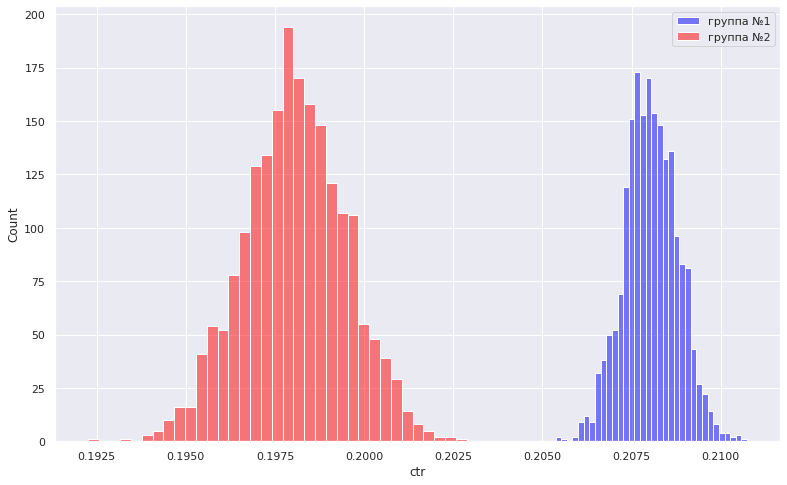

In [28]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.set_theme()
g = sns.histplot(ctr1, color='blue', alpha=0.5, label='группа №1')
g = sns.histplot(ctr2, color='red', alpha=0.5, label='группа №2')
plt.xlabel("ctr")
plt.legend()
plt.show()

***Вывод:*** как мы видим, получившиеся `ctr` целевой группы меньше, чем `ctr` контрольной группы. 

---

### Выводы АВ теста

В результате проведенного АВ теста для двух групп по сравнению эффективности рекомендательной системы были проведены два теста: `t-тест` и `Пуассоновский бутстреп`. 

В ходе первого тестирования было выявленно, что в случае введения новой системы рекомендаци недостаточно оснований пологать, что различия между группами статистически значемы. Т Для подтверждения результатов был дополнительно выбран метод сравнения - Пуассоновский бутстреп. Резульаты которого подтвердили результаты первого теста.

---